In [1]:
# Debugging the training

In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
dtype = torch.float
device = torch.device("cuda:0")

from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.sampling import FactorizedFlowPrior
from src.models.flows.analytic_flows.element_wise import AnalyticSigmoid

In [2]:
prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(1.2).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)

sig = AnalyticSigmoid(d=2)

In [4]:
nvp = RealNVP(d=2,
              mask=[True,False],
              d_hidden=10,
              n_hidden=5,).to(device)

with torch.no_grad():
    batch_size = 10
    x=sampler(batch_size)
    y=nvp(x)
    nvp.invert()
    z=nvp(y)
print((x-z)/(torch.abs(x)+torch.abs(z)))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0442e-07,  4.5452e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -3.2199e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  3.3798e-08,  0.0000e+00]], device='cuda:0')


In [5]:
print(nvp.transform.inverse)
print(nvp.transform(torch.tensor(5.),torch.tensor([1.,2.])))
nvp.invert()
print(nvp.transform.inverse)
print(nvp.transform(torch.tensor(5.),torch.tensor([1.,2.])))

True
(tensor(1.1036), tensor(-1.))
False
(tensor(15.5914), tensor(1.0000))


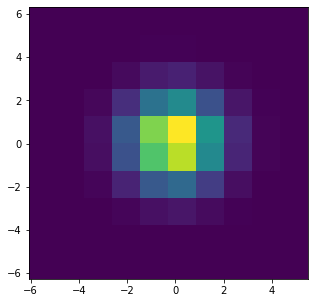

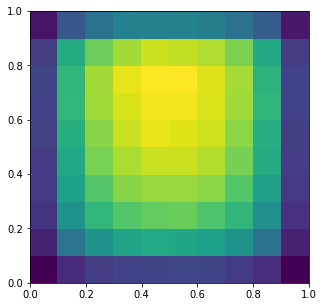

In [7]:
batch_size = 1000000
x=sampler(batch_size)
y=nvp(x)
z=sig(y)
y=y.detach().cpu().numpy()
z=z.detach().cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist2d(y[:,0],y[:,1])
plt.show()
plt.figure(figsize=(5,5))
plt.hist2d(z[:,0],z[:,1],range=((0,1),(0,1)))
plt.show()

In [37]:
def f(x):
    return torch.exp(- torch.sum((x/2.)**2,(-1,) ))

In [48]:
n_layers = 8

nvps = [RealNVP(d=2,
              mask=[True,False],
              d_hidden=4,
              n_hidden=512,).to(device) for _ in range(n_layers)]

params=[]
for nvp in nvps:
    params+=list(nvp.parameters())

optim = torch.optim.Adam(params,lr=1.e-4)

batch_size = 100000
x=sampler(batch_size)
for nvp in nvps:
    x = nvp(x)
z=sig(x)
z=z.detach().cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist2d(z[:,0],z[:,1],range=((0,1),(0,1)))
plt.show()
del x,z

def train_one_step():
    optim.zero_grad()
    x=sampler(batch_size)
    for nvp in nvps:
        x = nvp(x)
    z=sig(x)
    lj=-(z[:,-1])
    L=torch.mean(-torch.log(f(z[:,:-1]))+lj)
    Ls.append(L.detach().cpu().item())
    L.backward()
    optim.step()

batch_size=100000
Ls=[]
for i in range(600):
    train_one_step()
    if i>11 and Ls[-1] > np.mean(Ls[-11:-1])+3*np.std(Ls[-11:-1]):
        break
    
plt.plot(Ls)
plt.show()
print(Ls[-1])

batch_size = 100000
x=sampler(batch_size)
for nvp in nvps:
    x = nvp(x)
z=sig(x)
z=z.detach().cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist2d(z[:,0],z[:,1],range=((0,1),(0,1)))
plt.show()
del x,z

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 9.90 GiB already allocated; 4.25 MiB free; 9.90 GiB reserved in total by PyTorch)

In [ ]:
del nvps,optim,Ls

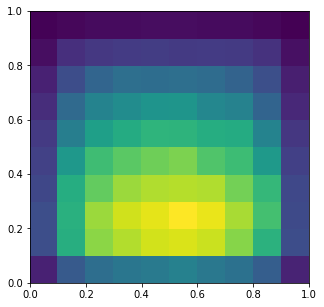

In [32]:
batch_size = 100000
x=sampler(batch_size)
for nvp in nvps:
    x = nvp(x)
z=sig(x)
z=z.detach().cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist2d(z[:,0],z[:,1],range=((0,1),(0,1)))
plt.show()